In [114]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# Specify each path

In [115]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.hdf5'
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

# Set number of classes

In [116]:
NUM_CLASSES = 8

# Dataset reading

In [117]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [118]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [119]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Model building

In [120]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [121]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_14 (Dropout)        (None, 42)                0         
                                                                 
 dense_21 (Dense)            (None, 20)                860       
                                                                 
 dropout_15 (Dropout)        (None, 20)                0         
                                                                 
 dense_22 (Dense)            (None, 10)                210       
                                                                 
 dense_23 (Dense)            (None, 8)                 88        
                                                                 
Total params: 1158 (4.52 KB)
Trainable params: 1158 (4.52 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [122]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [123]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [124]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
37/40 [==========================>...] - ETA: 0s - loss: 2.0259 - accuracy: 0.2181
Epoch 1: saving model to model/keypoint_classifier/keypoint_classifier.hdf5
40/40 [==============================] - 5s 28ms/step - loss: 2.0236 - accuracy: 0.2214 - val_loss: 1.9198 - val_accuracy: 0.3032
Epoch 2/1000
 8/40 [=====>........................] - ETA: 0s - loss: 1.9343 - accuracy: 0.2656

/home/yanxu/personalProjects/Object-Detection-Robot/env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


35/40 [=========================>....] - ETA: 0s - loss: 1.9316 - accuracy: 0.2679
Epoch 2: saving model to model/keypoint_classifier/keypoint_classifier.hdf5
40/40 [==============================] - 1s 13ms/step - loss: 1.9275 - accuracy: 0.2705 - val_loss: 1.8427 - val_accuracy: 0.3589
Epoch 3/1000
33/40 [=======================>......] - ETA: 0s - loss: 1.8664 - accuracy: 0.2786
Epoch 3: saving model to model/keypoint_classifier/keypoint_classifier.hdf5
40/40 [==============================] - 1s 13ms/step - loss: 1.8683 - accuracy: 0.2797 - val_loss: 1.7750 - val_accuracy: 0.3895
Epoch 4/1000
40/40 [==============================] - ETA: 0s - loss: 1.8103 - accuracy: 0.3037
Epoch 4: saving model to model/keypoint_classifier/keypoint_classifier.hdf5
40/40 [==============================] - 0s 11ms/step - loss: 1.8103 - accuracy: 0.3037 - val_loss: 1.7093 - val_accuracy: 0.3942
Epoch 5/1000
34/40 [========================>.....] - ETA: 0s - loss: 1.7545 - accuracy: 0.3274
Epoch 5: sa

In [125]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

14/14 [==============================] - 0s 7ms/step - loss: 0.5019 - accuracy: 0.9059


In [126]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [127]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 189ms/step
[1.40275648e-02 6.62553072e-01 1.76869631e-01 4.15966799e-03
 8.84735255e-06 1.07714575e-08 1.26883097e-04 1.42254338e-01]
1


# Confusion matrix

53/53 [==============================] - 0s 5ms/step


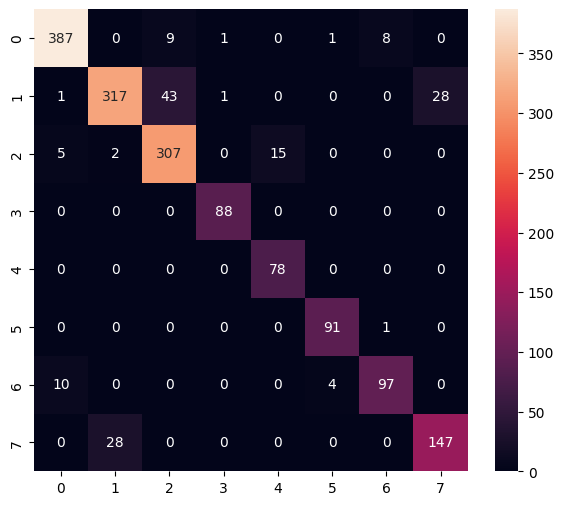

Classification Report
              precision    recall  f1-score   support

           0       0.96      0.95      0.96       406
           1       0.91      0.81      0.86       390
           2       0.86      0.93      0.89       329
           3       0.98      1.00      0.99        88
           4       0.84      1.00      0.91        78
           5       0.95      0.99      0.97        92
           6       0.92      0.87      0.89       111
           7       0.84      0.84      0.84       175

    accuracy                           0.91      1669
   macro avg       0.91      0.93      0.91      1669
weighted avg       0.91      0.91      0.91      1669



In [128]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [129]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

/home/yanxu/personalProjects/Object-Detection-Robot/env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [130]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: /tmp/tmp_6ylyb93/assets


INFO:tensorflow:Assets written to: /tmp/tmp_6ylyb93/assets
2024-01-17 19:36:39.122431: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-01-17 19:36:39.122531: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-01-17 19:36:39.123073: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp_6ylyb93
2024-01-17 19:36:39.127038: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-01-17 19:36:39.127147: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp_6ylyb93
2024-01-17 19:36:39.137476: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-01-17 19:36:39.274526: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmp_6ylyb93
2024-01-17 19:36:39.320837: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Unexpected exception formatting exception. Falling back to standard exception


: 3)
  (f32: 1)
Traceback (most recent call last):
  File "/home/yanxu/personalProjects/Object-Detection-Robot/env/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_2216/3071217658.py", line 5, in <module>
    tflite_quantized_model = converter.convert()
                             ^^^^^^^^^^^^^^^^^^^
  File "/home/yanxu/personalProjects/Object-Detection-Robot/env/lib/python3.11/site-packages/tensorflow/lite/python/lite.py", line 1139, in wrapper
    input_tensors: List of input tensors.
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/yanxu/personalProjects/Object-Detection-Robot/env/lib/python3.11/site-packages/tensorflow/lite/python/lite.py", line 1111, in _convert_and_export_metrics
    """
        
  File "/home/yanxu/personalProjects/Object-Detection-Robot/env/lib/python3.11/site-packages/tensorflow/lite/tools/flatbuffer_utils.py", line 93, in convert_object_

# Inference test

In [ ]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [ ]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [ ]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [ ]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

In [ ]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))